# Week 3. Day 3. Exercises from Chapter 9 of FSStDS. 
## Fundamentals of Social Data Science. MT 2022

Within your study pod discuss the following questions. Please submit an individual assignment by 12:30pm Monday, October 31st🎃, 2022 on Canvas. 

# Telling a story using multiple distributions and multiple media 

In this exercise, you are asked to show several skills that signal an accumulation of knowledge about research design in social data science. 

We are not expecting a complex statistical analysis. In fact, the goal should be to determine a simple approach wherever possible. 

Tell a story about a current event that enables you to make use of:
- Two different platforms. The default would be Twitter and Reddit, but you can flex your API skills should you choose. 
- At least one means comparison test (e.g., t-test or ANOVA)
- At least one correlation (determining whether it makes sense in a parametric or nonparametric form), 
- At least one scatterplot,
- At least one faceted distributional graph, such as a boxplot or violin plot.

**Step 1**. Link the story you tell to an intuition from either past literature, other current events, or personal experience. Please write it in a formal manner regardless of how you derive your intuitions. 

> For example, as a really simple case, "While crypto continues its descent in value, some communities appear adamant that it will continue to accrue in value. I explore the popularity of two cryptocurrencies: Ethereum and Monero by looking at the most recent posts discussing these currencies on Twitter and Reddit. By comparing the frequency over time of the last mentions of either, we can get a sense of how popular these currencies are, as well as whether they appear to benefit from organic content or suffer from scams and bots." 

**Step 2**. Describe the data you are collecting to make the comparison or explore the issue. Indicate what data makes sense and for what purpose

> For example, for Twitter, I am using the recent search and collecting the 5000 most recent mentions of "ethereum" and "monero". For each of these, I will examine whether there is a link in the tweet and the amount of public engagement from the tweet. For Reddit, I will be complementing this with a similar search using `praw`. Note: More details might be useful in your work

**Step 3**. Report the observations and their distributions as well as any issues you have encountered with sample size.  This should include visual presentations of the distributions.

**Step 4**. Report any bivariate or multivariate comparisons. If you have a hypothesis, restate it here and consider it in relation to the tests. This can include visual elements such as a heatmap or trendline.

**Step 5**. Reflect on findings in relation to the intuition or research motivation. 

This set of steps is loosely based on the structure of a research paper. The reason that I assert it is loosely based is because here we have slightly lower (or perhaps different) expectations. 
- In a research paper, we would expect the motivations for the analysis to be primarily based on academic conversations and past research.
- We wouldn't necessarily prescribe specific analyses _a priori_ in a paper. 
- Instead of merely reflecting on the quality of the tests we would want to link specific details back to the literature review or motivating concerns more directly. 
- We would probably pay much more attention to sample size and coverage. Here I have have made no specific demands of coverage except 'large enough to detect a reasonable difference'.  

Notes: 
1. Be careful with the means comparison tests. They are more likely to be reasonable within platform (one query to another or one subreddit to another) than between platform. 
2. The emphasis here is on setting up the argument with data and examining the shape of that data. We should exercise caution on generalisibility. However, it is worth considering that at least superficially by collecting more than 100 tweets or posts. 
3. You can use another platform, but please use a hot API and not a prepared data dump. 
4. It is not assumed that someone reading this paper will be able to collect the same data as you, so segment your code in such a way that you download and collect a suitable sample and then in another part perform any relevant subsequent analyses. 

You can submit the data alongside the code then so that someone can reproduce the findings. Please note that actual tweet data can only be shared within class and any public archive of this work should exclude the tweet to be rehydrated as per Twitter's Developer Terms.   

There is no rubric for this exercise. It will be graded by the course instructor and given both small amounts of qualitative feedback and a grade out of 100 on the Oxford scale (that is where 50 is a pass, 65 is a strong pass, 70 is a distinction). It will be returned in one week from submission.

# Step 1. Set up the motivations
Twitter plays a crucial role in disseminating research findings (Klar et al., 2020). This is despite some apparently counter-academic features, notably the 280 character limit, which intuitively should limit complex discourse. A platform that has the features that promote longer discussions is Reddit. Nevertheless, scientists seem to use Reddit more for public outreach through so-called AMAs (Ask Me Anything), rather than peer promotion (Hara et al., 2019). 

These different considerations plausibly affects the linguistic complexity of the discourse on the two platforms. However, the directionality of the effect is hard to predict: does the more academic audience of Twitter outweigh the shorter format? Or does the long-form compatability of Reddit promote more long-form discourse? A concrete way preferences for linguistic complexity could be expressed is through more complex posts getting more points (either retweets / favourites or upvotes depending on the platform). This would as show up in the data as a relatively stronger correlation between linguistic complexity for one platform over the other. Is that the case for machine learning data?

This project aims to answer the above question. Through collecting machine learning research discussions on both Twitter and Reddit, I will analyse whether there exists a significant difference between the platforms in a) their linguistic complexity and b) their correlation between linguistic complexity and post popularity. I will then discuss the limitations and opportunities of the analysis and to what extent it generalizes to other fields. 



# Step 2. Describe the data 
Before describing the data collection, I want to operationalise the central concept of "linguistic complexity". In general, I will take linguistic complexity to mean _readability_, which is a well-studied field (see Klare, 1974). However, with study comes disagreement, which has lead to a plethora of readability formulas with differing complexity and purpose from the straightforward (and hilariously named) "Simple Measure of Gobbledygook (SMOG)" (McLaughlin 1969) to more complex multivariate procedures like the Bormuth Formulas (Bormuth 1966). For the purpose of this study, I will use the Dale-Chall formula (Dale & Chall, 1948), which uses a combination of unfamiliar words and average sentence length. This captures two key factors of variance (Klare 1974) as well as being easy to implement through the [`py-readability-metrics`](https://github.com/cdimascio/py-readability-metrics#dale-chall-readability) library. 

Now I will turn to the data collection, starting with Twitter. For collecting the data, I will use the Twitter API V2 with academic access. This allows me to get a more complete picture than with standard access. The specific query will be tweets containing `#NeurIPS2022` and `#AAAI2022`. NeurIPS and AAAI are both leading conferences within Machine Learning. Many researchers publish so-called threads describing their research. To gain enough statistical power for measuring Dale-Chall readability, my unit of analysis will be these threads. I will identify these threads using the newly-added `conversation_id`. This, however, also limits the analysis to 2022 data, as the `conversation_id` parameter was not introduced before.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import praw
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from datetime import datetime
from typing import Optional, Tuple,Dict, List
from tqdm import tqdm
from pathlib import Path
from readability import Readability
import re
import functools

def read_json(filepath: Path) -> dict:
    """Reads a JSON file and returns a dictionary"""
    with open(filepath, "r") as f:
        return json.load(f)
def sum_public_metrics(tweet: dict) -> int:
    """Sums the public metrics of a tweet"""
    return sum(tweet["public_metrics"].values())

def scrape_thread(conversation_id: str, headers: dict, tweet_fields: str) -> Optional[dict]:
    """Scrapes a thread of tweets based on a conversation_id"""
    tweet_url = "https://api.twitter.com/2/tweets/search/all"
    params = {"query": f"conversation_id:{conversation_id}", "tweet.fields": tweet_fields, "max_results": 100}
    r = requests.get(tweet_url, headers=headers, params=params)
    r.raise_for_status()
    if "data" not in r.json():
        return None
    return r.json()

def remove_user_names(text: str) -> str:
    """Removes user names from a string"""
    return re.sub(r"@\w+", "", text)

def remove_urls(text: str) -> str:
    """Removes URLs from a string"""
    return re.sub(r"http\S+", "", text)

def remove_hashtags(text: str) -> str:
    """Removes hashtags from a string"""
    return re.sub(r"#\w+", "", text)

def compose(*funcs):
    """Composes functions"""
    def inner(arg):
        return functools.reduce(lambda x, f: f(x), funcs, arg)
    return inner

def clean_text(text: str) -> str:
    """Cleans text"""
    clean_func = compose(remove_user_names, remove_urls, remove_hashtags)
    return " ".join(clean_func(text).split())

def create_convo_text(convo: List[dict]) -> str:
    """Creates a string of all the tweets in a conversation"""
    joined_text = "\n".join([tweet["text"] for tweet in convo])
    return clean_text(joined_text)

def get_dale_chall(text: str) -> float:
    """Gets the Dale-Chall readability score"""
    return Readability(text).dale_chall().score

def comment_dict(comment: praw.models.Comment) -> dict:
    return {"body": comment.body, "id": comment.id, "parent_id": comment.parent_id, "score": comment.score}

def normalise_series(series: pd.Series) -> pd.Series:
    """Normalises a series using mean and standard deviation"""
    return (series - series.mean()) / series.std()


def compare_correlations(corr1: float, corr2: float, n1: int, n2: int) -> Tuple[float, float]:
    """Implements Fisher's Z-score comparison. Python implementation adapted from Singer (2022)"""
    xy_z = 0.5 * np.log((1 + corr1)/(1 - corr1))
    ab_z = 0.5 * np.log((1 + corr2)/(1 - corr2))
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - stats.norm.cdf(z)) * 2 # two-tailed test
    return z, p 

In [2]:
# Collecting the initial twitter data

config = read_json(Path("../twitter_config.json"))
headers = {"Authorization": f"Bearer {config['bearer_token']}"}
twitter_query = '(#NeurIPS2022 OR #AAAI2022) -is:retweet'
tweet_fields = "author_id,created_at,text,public_metrics,conversation_id"
tweet_url = "https://api.twitter.com/2/tweets/search/all"
params = {"query": twitter_query, "tweet.fields": tweet_fields, "max_results": 500}
r = requests.get(tweet_url, headers=headers, params=params)

In [89]:
initial_df = pd.json_normalize(r.json()['data'])
unique_convo_ids = initial_df['conversation_id'].unique()

349

In [3]:

# Filtering the initial twitter data to only include sufficiently long threads.
old_data = pd.read_csv("../data/long_ml_tweet_convos.csv")
unique_convo_ids = old_data['conversation_id'].unique()


# Collecting all the tweets in the threads (takes a while)
convo_list = []
metric_list = []
conversation_ids = []
tweet_ids = []
for convo_id in tqdm(unique_convo_ids):
    raw_convo = scrape_thread(convo_id, headers, tweet_fields)
    if raw_convo is None:
        continue
    clean_convo = create_convo_text(raw_convo["data"])
    mean_convo_reach = np.mean([sum_public_metrics(tweet) for tweet in raw_convo["data"]])
    metric_list.append(mean_convo_reach)
    convo_list.append(clean_convo)
    conversation_ids.append(convo_id)
    tweet_ids.append([tweet["id"] for tweet in raw_convo["data"]])





100%|██████████| 76/76 [04:29<00:00,  3.55s/it]


In [5]:
tweet_convo_df = pd.DataFrame({"text": convo_list, "popularity_score": metric_list, "conversation_id": conversation_ids,})
tweet_convo_df["number_of_words"] = tweet_convo_df["text"].apply(lambda x: len(x.split()))
long_tweet_convos = tweet_convo_df[tweet_convo_df["number_of_words"] > 99]
long_tweet_convos["readability_score"] = long_tweet_convos["text"].apply(get_dale_chall)

C:\Users\jhr\AppData\Local\Temp\ipykernel_8940\4178981681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_tweet_convos["readability_score"] = long_tweet_convos["text"].apply(get_dale_chall)


In [7]:
long_tweet_convos.to_csv("../data/long_ml_tweet_convos.csv", index=False)

For the Reddit data, I will scrape posts from the "r/MachineLearning" subreddit using [PRAW](LINK) (Boe, 2022). I will focus on the comment sections of posts discussing research (denoted with an `[R]` tag in the title). I investigate comments rather than posts as many posts are simply links to articles or extracts from papers, which does not show Reddit-specific discourse. 

In [8]:
reddit_config = read_json(Path("../reddit_config.json"))
reddit = praw.Reddit(client_id=reddit_config["client_id"],
                        client_secret=reddit_config["client_secret"],
                        user_agent="User: reddit-scraper by /u/RyzzleStrizzle")

subreddit = reddit.subreddit("MachineLearning")

reddit_convos = []
for submission in tqdm(subreddit.search("[R]", limit=100)):
    # remove comment limit
    submission.comments.replace_more(limit=None)
    for comment in submission.comments:
        if comment.is_root:
            convo = [comment_dict(comment)] + [comment_dict(reply) for reply in comment.replies]
            reddit_convos.append(convo)

100it [06:13,  3.73s/it]


In [10]:

# Formatting the Reddit data into a dataframe #
clean_reddit_convos = [clean_text(" ".join(text["body"] for text in convo)) for convo in reddit_convos]
mean_convo_score = [np.mean([comment["score"] for comment in convo]) for convo in reddit_convos]
reddit_convo = pd.DataFrame({"text": clean_reddit_convos, "score": mean_convo_score})
reddit_convo["num_words"] = reddit_convo["text"].apply(lambda x: len(x.split()))
long_reddit_convos = reddit_convo[reddit_convo["num_words"] > 99]
long_reddit_convos["readability_score"] = long_reddit_convos["text"].apply(get_dale_chall)

In [13]:
long_reddit_convos.to_csv("../data/reddit_ml_convo.csv", index=False)

# Step 3. Report the observations and their distributions
~~~
# Answer here. This might include figures as well as code and markdown
~~~

For each data source, we have two variables of interest: Dale-Chall readability score as well as a popularity score. While the Dale-Chall scores can straightforwardly be compared between the platforms, the popularity scores need further operationalisation. For the Twitter data, I will define popularity as the mean sum of the "public metrics" (retweets, likes, and quote tweets) over the. The reddit popularity score is simply the mean comment score. To account for differences in the two platforms, I normalise the results by subtracting the mean and dividing by the standard deviation of the sample. 

For visualising the two distributions, I use a faceted density plot. This gives a direct and easily comparable view into the underlying distribution without relying on simplifying summaries. In contrast, boxplots can distort the underlying data by hiding potential bimodality as explained in [this post](https://www.data-to-viz.com/caveat/boxplot.html). One drawback of density visualisations is the lack of information about the sample size. I remedy this by adding sample size to the legend.

Below is a visualisation of the popularity:

C:\Users\jhr\AppData\Local\Temp\ipykernel_8940\312737959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_tweet_convos["normalised_popularity"] = normalise_series(long_tweet_convos["popularity_score"])
C:\Users\jhr\AppData\Local\Temp\ipykernel_8940\312737959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reddit_convos["normalised_popularity"] = normalise_series(long_reddit_convos["score"])


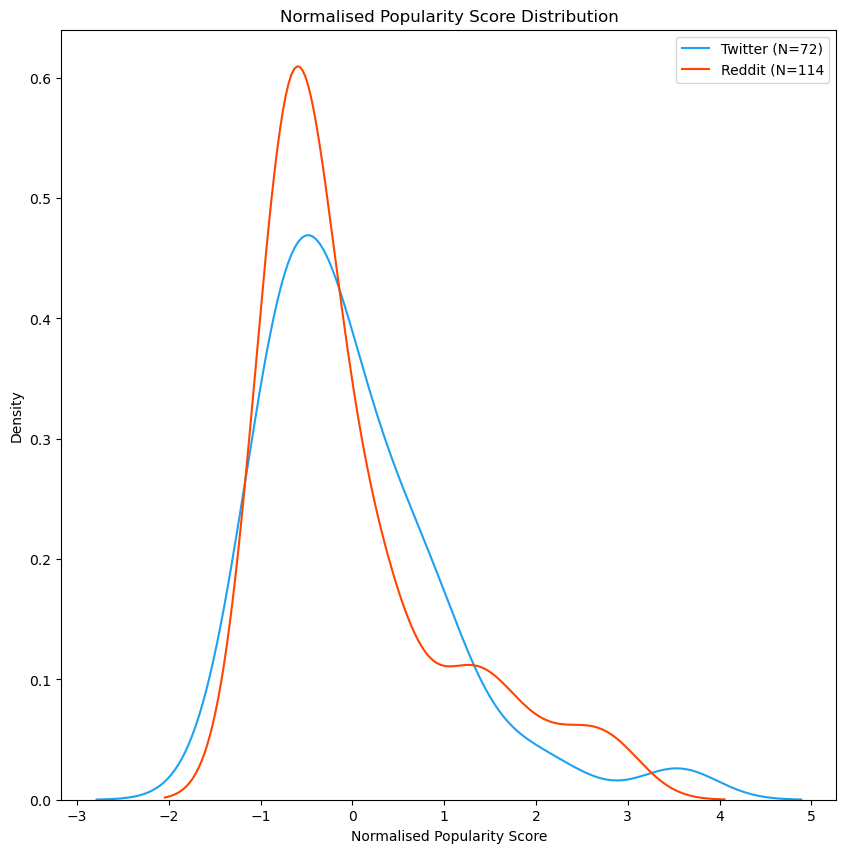

In [14]:

twitter_color = "#1DA1F2"
reddit_color = "#FF4500"
long_tweet_convos["normalised_popularity"] = normalise_series(long_tweet_convos["popularity_score"])
long_reddit_convos["normalised_popularity"] = normalise_series(long_reddit_convos["score"])

# plot the normalised popularity scores (density)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.kdeplot(long_tweet_convos["normalised_popularity"], ax=ax, label=f"Twitter (N={len(long_tweet_convos)})", color=twitter_color)
sns.kdeplot(long_reddit_convos["normalised_popularity"], ax=ax, label=f"Reddit (N={len(long_reddit_convos)})", color=reddit_color)
ax.set_xlabel("Normalised Popularity Score")
ax.set_ylabel("Density")
ax.set_title("Normalised Popularity Score Distribution")
ax.legend()
plt.show()

We see from the plot that the two distributions occupy approximately similar ranges as well as both exhibiting a slight right skew. 

Now we turn to the readability scores:

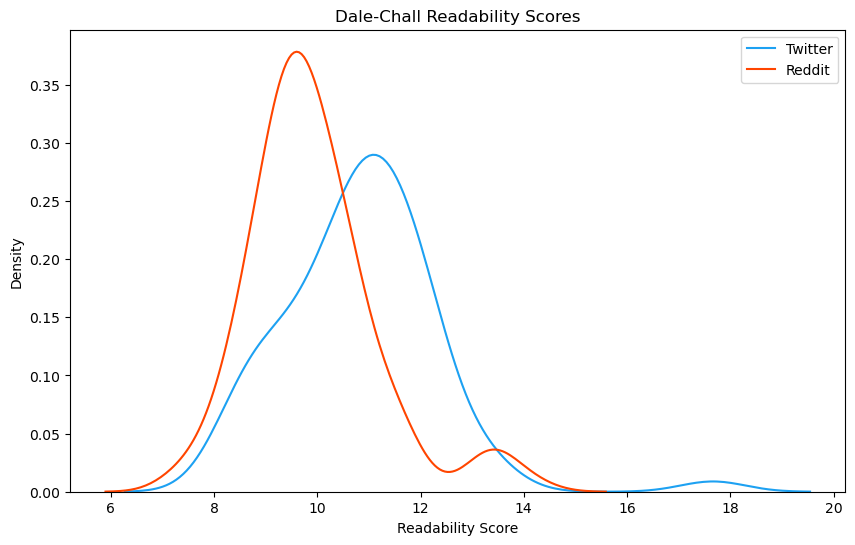

In [15]:

# Plot the two distributions
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(long_tweet_convos["readability_score"], ax=ax, label=f"Twitter (N={len(long_tweet_convos)})", color=twitter_color)
sns.kdeplot(long_reddit_convos["readability_score"], ax=ax, label=f"Reddit (N={len(long_reddit_convos)})", color=reddit_color)
ax.set_title("Dale-Chall Readability Scores")
ax.set_xlabel("Readability Score")
ax.set_ylabel("Density")
ax.legend()
plt.show()

The readability scores show somewhat more discrepency than the popularity scores: The Twitter distribution has a longer right-tail as well as a broader peak more to the right. The Reddit distribution, on the other hand, has a narrower peak centered around 10. To assess the statistical significance of the differences, however, requires doing a statistical test. Because of the relative non-normality and skew of the readability distributions, I will use a Mann-Whitney U-test (Mann & Whitney, 1948) to compare them. The results can be seen below.

In [17]:
# run mann-whitney u test
t_test_result = stats.mannwhitneyu(long_tweet_convos["readability_score"], long_reddit_convos["readability_score"])
# report results
print(f"U-statistic: {t_test_result[0]}\np-value: {t_test_result[1]:.10f}")

U-statistic: 5837.0
p-value: 0.0000012710


We observe a highly significant difference in means.

# Step 4. Report any bivariate or multivariate comparisons
As previously mentioned, the main bivariate comparison is between the readability index and popularity score across the two platforms. My analysis has two stages. First, I calculate the (Spearman) correlation within each of the platforms (Spearman, 1904). I use Spearman correlation (rather than the more popular Pearson) as the distributions lack normality. This does not drastically change the interpretation of the findings. 

The second stage is to test whether the correlation coefficients are significantly different from each other as per my second hypothesis. For this I will use a test of Fisher's Z transformation (Fisher, 1921). I use this as the two correlations are independent from each other by coming from different platforms. 

For visualising the results I will employ a scatter plot with a regression line per platform. This provides a sanity check of the results as well as visual intuitions for the strength of the association (or lack thereof). 

Twitter correlation: -0.051 (p-value: 0.673)
Reddit correlation: 0.050 (p-value: 0.597)
Correlation difference p-value: 0.511


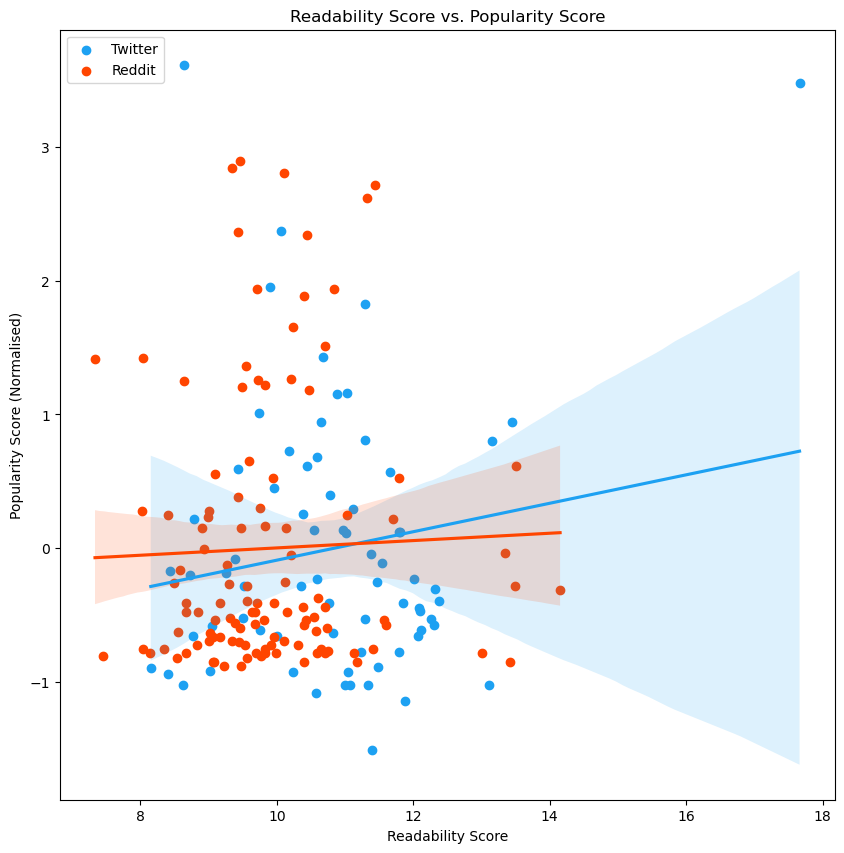

In [18]:

# calculate the correlation between readability score and popularity score
tweet_cor = stats.spearmanr(long_tweet_convos["readability_score"], long_tweet_convos["popularity_score"])
reddit_cor = stats.spearmanr(long_reddit_convos["readability_score"], long_reddit_convos["score"])
z, p = compare_correlations(tweet_cor[0], reddit_cor[0], n1=len(long_tweet_convos), n2=len(long_reddit_convos))

# report results
print(f"Twitter correlation: {tweet_cor[0]:.3f} (p-value: {tweet_cor[1]:.3f})")
print(f"Reddit correlation: {reddit_cor[0]:.3f} (p-value: {reddit_cor[1]:.3f})")
print(f"Correlation difference p-value: {p:.3f}")

# plot scatter plot of readability score vs. popularity score
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(long_tweet_convos["readability_score"], long_tweet_convos["normalised_popularity"], label="Twitter", c=twitter_color)
ax.scatter(long_reddit_convos["readability_score"], long_reddit_convos["normalised_popularity"], label="Reddit", c=reddit_color)
# add regression lines with confidence intervals
sns.regplot(x="readability_score", y="normalised_popularity", data=long_tweet_convos, ax=ax, scatter=False, color=twitter_color)
sns.regplot(x="readability_score", y="normalised_popularity", data=long_reddit_convos, ax=ax, scatter=False, color=reddit_color)
ax.set_xlabel("Readability Score")
ax.set_ylabel("Popularity Score (Normalised)")
ax.set_title("Readability Score vs. Popularity Score")
ax.legend(loc="best")
plt.show()



We observe very small correlations as well as no significant difference between the coefficients. (note: I deliberately avoid writing numbers in the markdown as these change slightly depending on the data). 

# Step 5. Reflect on findings in relation to setup
This work set out to investigate the difference in readability (and popularity norms as a possible mechanism) in machine learning discourse on Twitter and Reddit respectively. For the first hypothesis regarding whether there was a difference in readability, we find highly significant results. For the second hypothesis regarding whether there is a difference in the association of readability and popularity between the two platforms, we find no significant results for neither the difference between the platforms nor the associations within the platforms. We thus cannot reject the null hypothesis in that case. 

There are several methodological limitations that affect the validity and generalisability of these results. Firstly, I did not account for repeated measures in the analyses. This might have inflated the p-value and reduced the power of the analysis (Sainani, 2010). However, the design of the study made it difficult to define repeated measures as the analysis was on a thread-level. Multiple users participated in these threads making identity difficult. Furthermore, some users might have been present in both datasets under different pseudonyms further complicating the analysis. Limiting the analysis to single user Twitter threads and sufficiently long Reddit comments would have partially remedied the problems. However, this would have reduced the amount of data as well as shifted the focus away from conversations.

Secondly, there is a bias in the selection criteria between the platforms. As previously stated, NeurIPS and AAAI are top-level machine learning conferences, which makes many "conversations" about jargonic paper summarisation threads. R/machinelearning on the other hand generally has a more applied focus and a more junior user base. I tried to circumvent this by only scraping research-specific discussions.

Given the above factors, one should be careful with generalising the findings. A conservative claim is that machine learning _research_ discourse has a higher linguistic complexity on Twitter rather than Reddit. However, this does not necessarily generalise to other fields of research or types of machine learning discourse (e.g. discussions about practical applications). We also cannot draw any inferences about the causes of this difference. It is definitely also inappropriate to draw conclusions about "science" Twitter versus "science" Reddit as these terms cover heterogeneous scientific communities with different norms and interaction patterns. 

Future research could investigate the generalisability, robustness, and underlying mechanisms of these findings. The work could expand the methodology to other scientific fields. On scale this work might shed light on whether the relative complexity of Twitter is a general pattern. Regarding the mechanisms, one could approach the question from multiple directions. One is to etnographically investigate _how_ researchers use Twitter and Reddit respectively. This could lay the abductive foundation for testable hypotheses. One might also want to investigate the phenomenon inductively to assess whether it is possible to predict the differences using quantitative features. This work could also promote potential deductive hypotheses. 

## Bibliography
Bormuth, J. R. (1966). Readability: A new approach. Reading Research Quarterly, 79–132.

Boe, B. (2022). PRAW: The Python Reddit API Wrapper [Python]. Python Reddit API Wrapper Development. https://github.com/praw-dev/praw (Original work published 2010)

Dale, E., & Chall, J. S. (1948). A formula for predicting readability: Instructions. Educational Research Bulletin, 37–54.

Fisher, R. A. (1921). 014: On the" Probable Error" of a Coefficient of Correlation Deduced from a Small Sample.

Hara, N., Abbazio, J., & Perkins, K. (2019). An emerging form of public engagement with science: Ask Me Anything (AMA) sessions on Reddit r/science. PLOS ONE, 14(5), e0216789. https://doi.org/10.1371/journal.pone.0216789

Klar, S., Krupnikov, Y., Ryan, J. B., Searles, K., & Shmargad, Y. (2020). Using social media to promote academic research: Identifying the benefits of twitter for sharing academic work. PLOS ONE, 15(4), e0229446. https://doi.org/10.1371/journal.pone.0229446

Klare, G. R. (1974). Assessing Readability. Reading Research Quarterly, 10(1), 62–102. https://doi.org/10.2307/747086

Mann, H. B., & Whitney, D. R. (1947). On a test of whether one of two random variables is stochastically larger than the other. The Annals of Mathematical Statistics, 50–60.

Mc Laughlin, G. H. (1969). SMOG grading-a new readability formula. Journal of Reading, 12(8), 639–646.

Sainani, K. (2010). The importance of accounting for correlated observations. PM&R, 2(9), 858–861.

Singer, P. (2022). CorrelationStats [Python]. https://github.com/psinger/CorrelationStats (Original work published 2013)

Spearman, C. (1904). The Proof and Measurement of Association between Two Things. The American Journal of Psychology, 15(1), 72–101. https://doi.org/10.2307/1412159


